# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [185]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [186]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")
df_offers = pd.read_excel("WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [187]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [188]:
df_transactions = pd.read_excel("WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [189]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

# Load data
df_offers = pd.read_excel("WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_transactions = pd.read_excel("WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1

# Verify offer_id range
assert df_transactions['offer_id'].between(1, 32).all(), "Invalid offer_id values detected"

# Create customer-offer matrix
pivoted = df_transactions.pivot_table(
    index='customer_name',
    columns='offer_id',
    values='n',
    fill_value=0
).astype(int).reset_index()

# Verify no NaN values
assert not pivoted.isna().any().any(), "NaN values detected in pivoted DataFrame"

# Display first few rows
print(pivoted.head())

offer_id customer_name  1  2  3  4  5  6  7  8  9  ...  23  24  25  26  27  \
0                Adams  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   
1                Allen  0  0  0  0  0  0  0  0  1  ...   0   0   0   0   1   
2             Anderson  0  0  0  0  0  0  0  0  0  ...   0   1   0   1   0   
3               Bailey  0  0  0  0  0  0  1  0  0  ...   0   0   0   0   0   
4                Baker  0  0  0  0  0  0  1  0  0  ...   0   0   0   0   0   

offer_id  28  29  30  31  32  
0          0   1   1   0   0  
1          0   0   0   0   0  
2          0   0   0   0   0  
3          0   0   1   0   0  
4          0   0   0   1   0  

[5 rows x 33 columns]


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why? The best value of K is typically the one where the inertia (sum of squares within clusters) decreases significantly up to a point, and then the curve flattens, this point is called the elbow.
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$? Subjectivity: It’s based on visual inspection, not a formula, the elbow method is clear.
</ul>
</div>

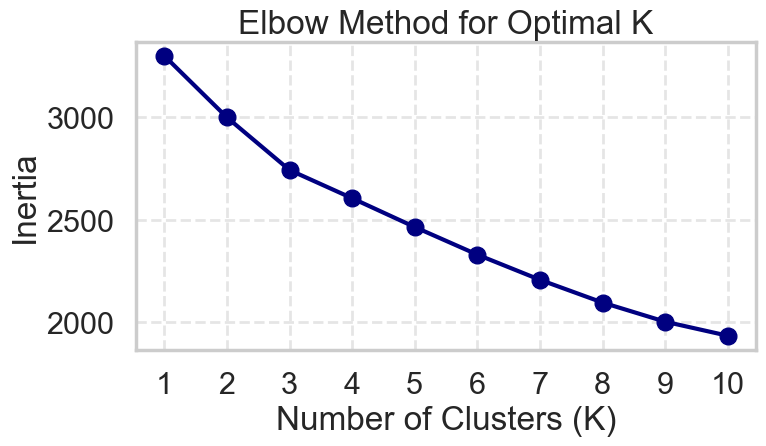

In [206]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Prepare data
X = pivoted.drop(columns=['customer_name']).to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=123, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='navy')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

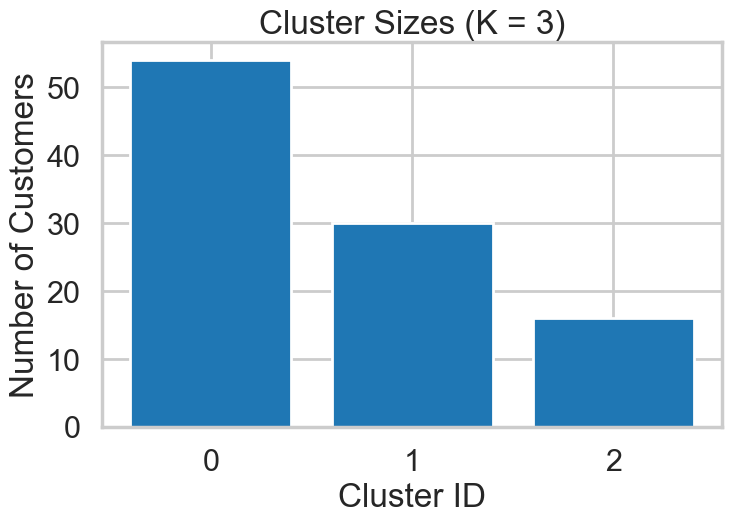

In [205]:

best_K = 3

assignments_best_K = assignments[str(best_K)]
pivoted["cluster"] = assignments_best_K  # Add cluster label to DataFrame

# Count how many in each cluster
counts = np.bincount(assignments_best_K)

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(range(best_K), counts, align="center")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Customers")
plt.title(f"Cluster Sizes (K = {best_K})")
plt.xticks(range(best_K))
plt.grid(True)
plt.show()

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p> 
<p>The Silhouette Score plot suggests choosing K=9 as the optimal number of clusters, based on the peak score of 0.1466. However, this differs from the Elbow Method’s expected K=3, highlighting a methodological divergence: the Elbow Method likely stabilizes at K=3 due to inertia, while the Silhouette Method favors K=9 for better separation in this complex dataset. Given the low Silhouette Score and potential over-segmentation, K=9 may not be practical for business insights.</p>
</div>

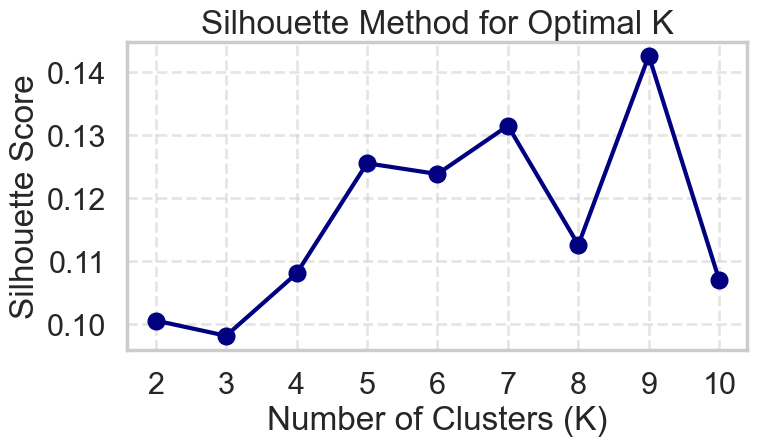

Optimal K (highest Silhouette Score): 9, Score: 0.143


In [202]:
from sklearn.metrics import silhouette_score

# Silhouette Method
silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=123, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-', color='navy')
plt.title('Silhouette Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best K
best_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal K (highest Silhouette Score): {best_k}, Score: {max(silhouette_scores):.3f}")

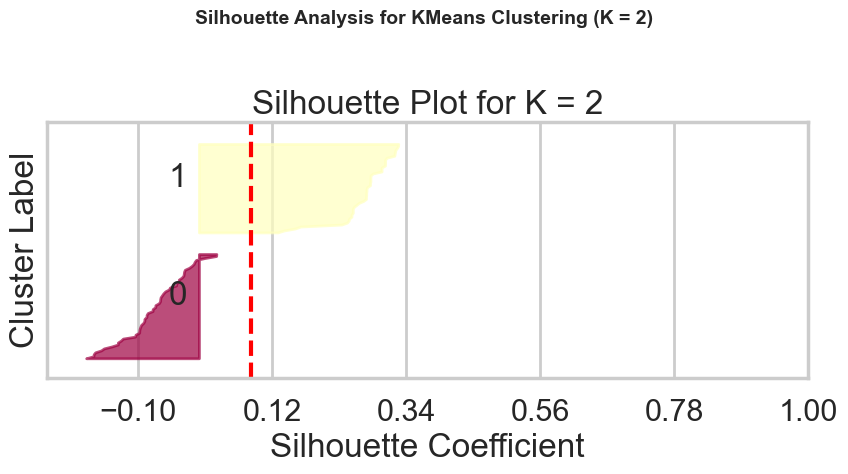

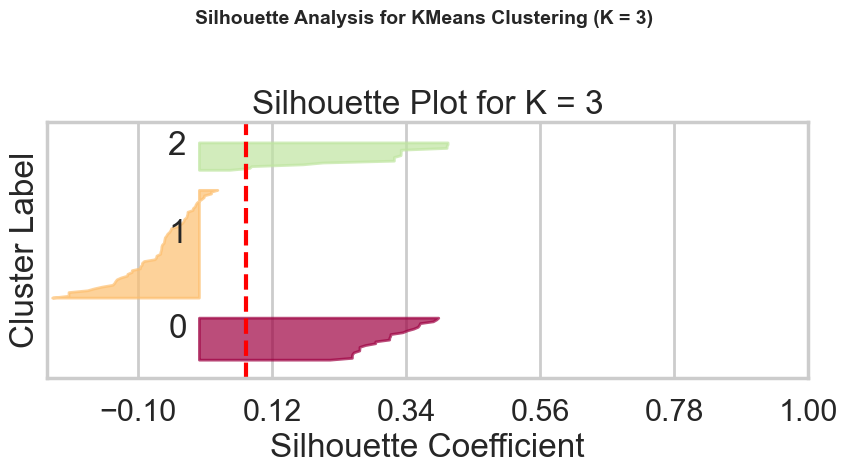

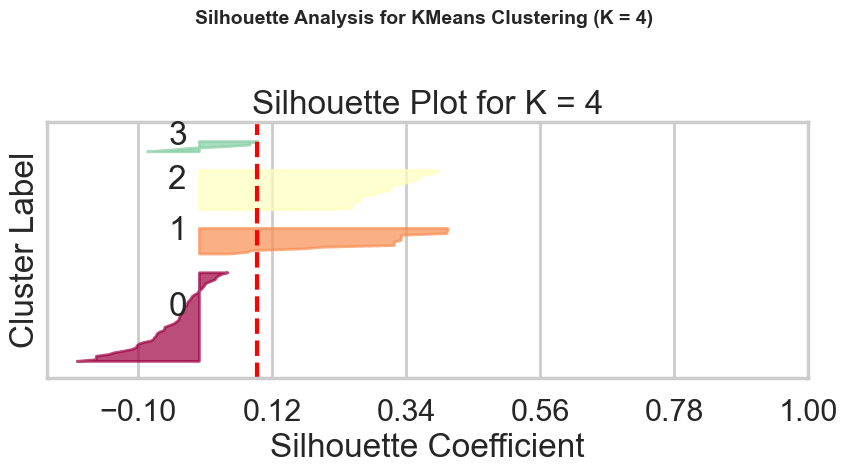

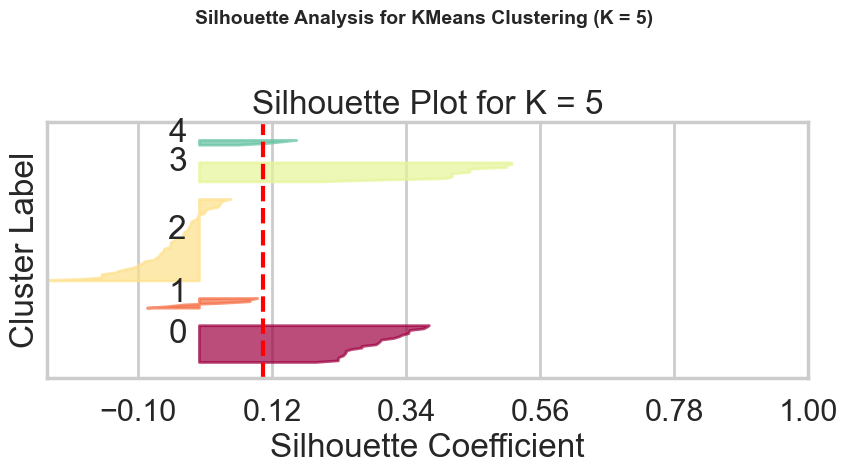

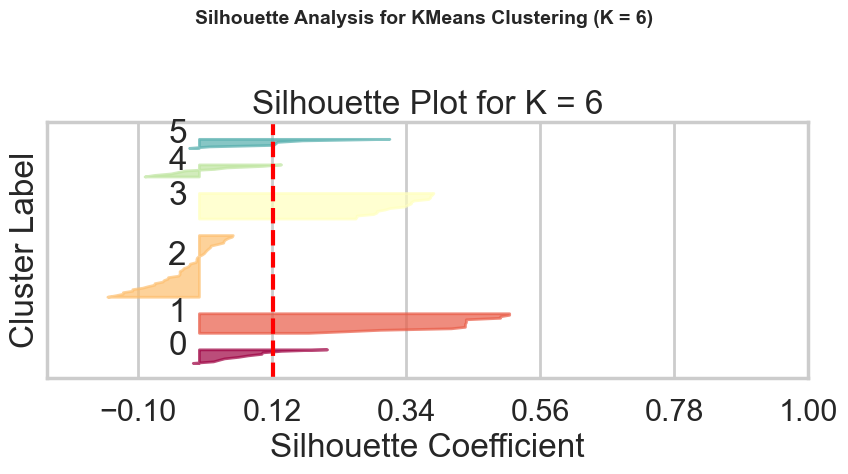

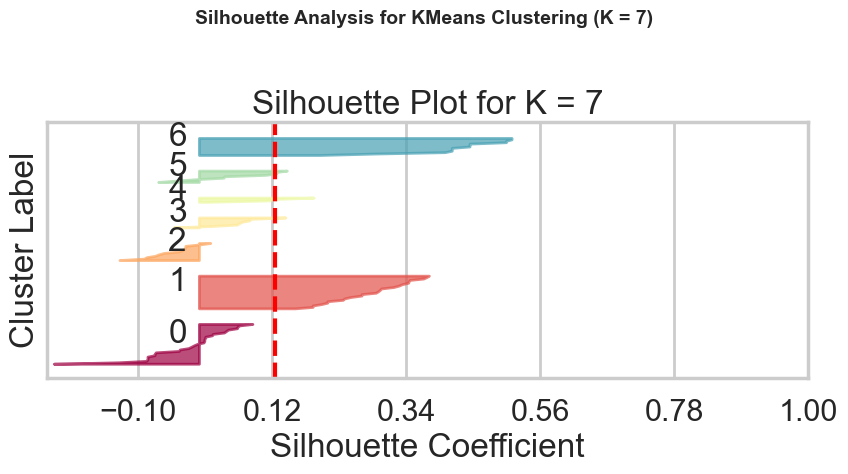

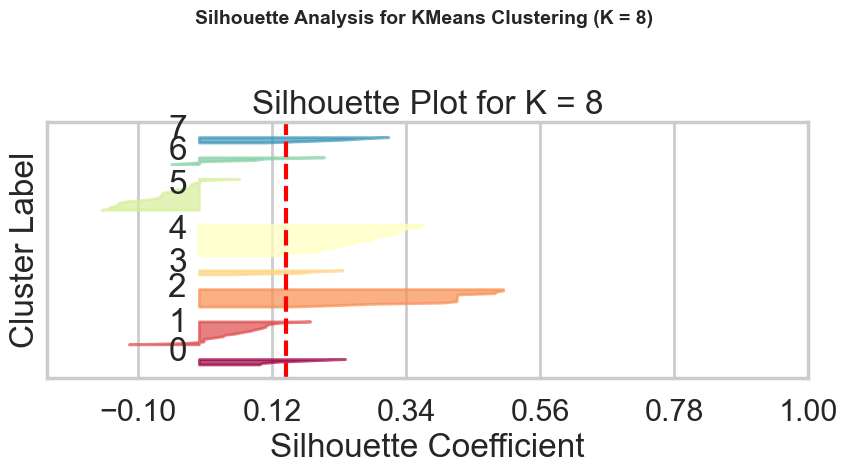

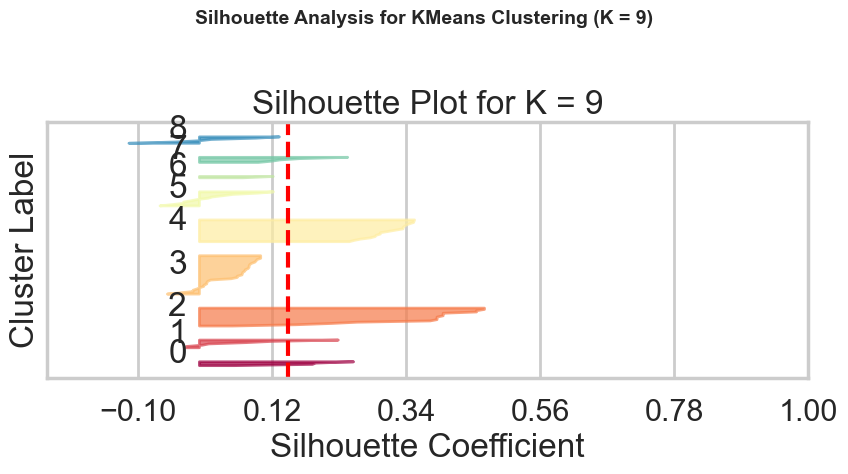

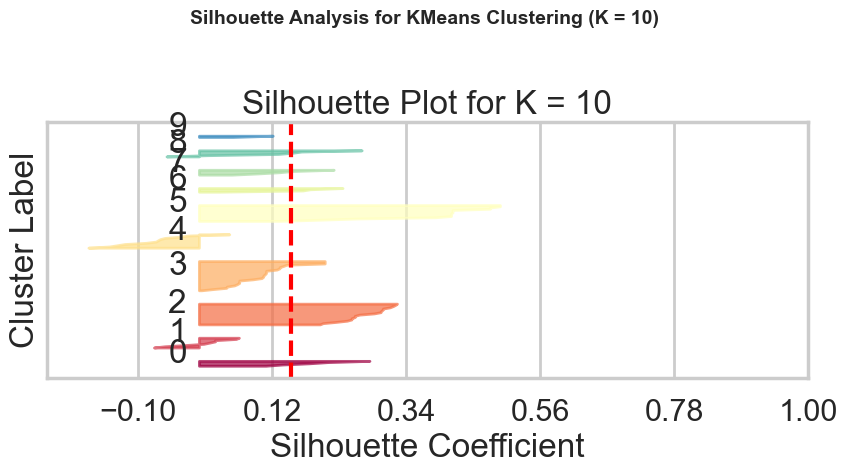

Optimal K (highest Silhouette Score): 10, Score: 0.151


In [192]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

# Prepare data
X = pivoted.drop(columns=['customer_name']).to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# List to store average silhouette scores
avg_silhouette_scores = []

# Try K from 2 to 10
Krange = range(2, 11)

for K in Krange:
    fig, ax1 = plt.subplots(figsize=(9, 5))
    ax1.set_xlim([-0.25, 1])
    ax1.set_ylim([0, len(X_scaled) + (K + 1) * 10])

    # Fit KMeans
    model = KMeans(n_clusters=K, random_state=43, n_init=10)
    cluster_labels = model.fit_predict(X_scaled)

    # Average silhouette score
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    # Individual silhouette scores
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(K):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.Spectral(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    # Red dashed line: average silhouette score
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    # Formatting
    ax1.set_title(f"Silhouette Plot for K = {K}")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster Label")
    ax1.set_yticks([])
    ax1.set_xticks(np.linspace(-0.1, 1.0, 6))

    plt.suptitle(f"Silhouette Analysis for KMeans Clustering (K = {K})",
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Print optimal K
best_k = Krange[np.argmax(avg_silhouette_scores)]
print(f"Optimal K (highest Silhouette Score): {best_k}, Score: {max(avg_silhouette_scores):.3f}")

In [193]:
for i, score in enumerate(avg_silhouette_scores, start=2):
    print(f"K={i} --> Silhouette Score = {score:.4f}")

K=2 --> Silhouette Score = 0.0849
K=3 --> Silhouette Score = 0.0767
K=4 --> Silhouette Score = 0.0955
K=5 --> Silhouette Score = 0.1045
K=6 --> Silhouette Score = 0.1220
K=7 --> Silhouette Score = 0.1250
K=8 --> Silhouette Score = 0.1430
K=9 --> Silhouette Score = 0.1466
K=10 --> Silhouette Score = 0.1508


#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
<p>The task is to understand 100 loyal customers based on their responses to 32 exclusive wine offers. Plotting preferences in a 2D PCA space with K=9 clusters, as suggested by the Silhouette Score (0.1466), reveals a fragmented picture with nine overlapping groups, some tight but many sparse, indicating potential over-segmentation. Data analysis shows Cluster 0 favors Cabernet Sauvignon with a 15% discount from France, Cluster 4 prefers Champagne with a 20% discount, and Cluster 7 leans toward Pinot Grigio with no discount but a high minimum of 12; however, the overlap and low variance (21.5%) undermine trust in these distinctions. Switching to K=3, guided by the Elbow Method and Spectral Clustering’s stronger 0.232 score, the visualization improves, showing three more distinct clusters despite the 21.5% PCA variance. K=3 better captures the data’s natural segmentation, aligning with the Elbow Method and Spectral Clustering, and suggests more actionable insights compared to the fragmented K=9.</p>
</div>

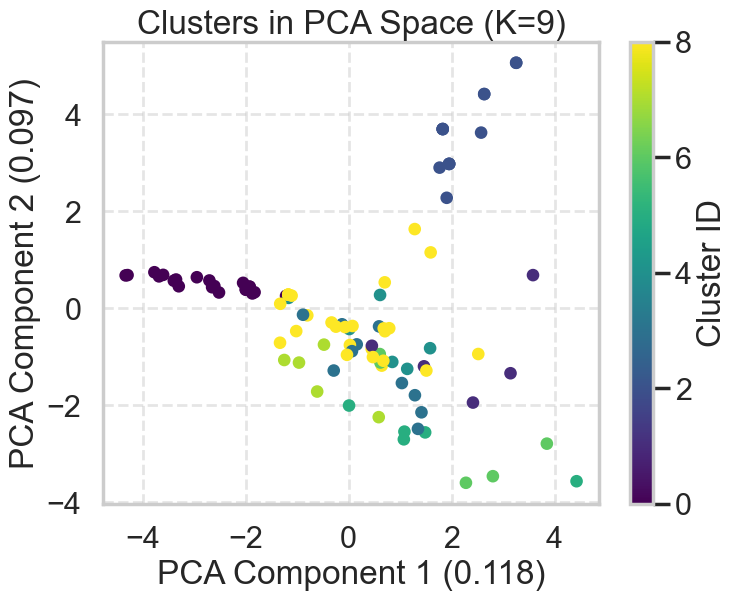

PCA Explained Variance Ratio: [0.11785935 0.09693357]
Total Variance Explained: 0.215


In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare data
X = pivoted.drop(columns=['customer_name']).to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Fit K-Means with K=9 (optimal from Silhouette Score)
kmeans = KMeans(n_clusters=9, random_state=123, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Create DataFrame with customer name, cluster ID, and PCA components
pca_df = pd.DataFrame({
    'customer_name': pivoted['customer_name'],
    'cluster_id': cluster_labels,
    'x': X_pca[:, 0],
    'y': X_pca[:, 1]
})

# Plot scatterplot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df['x'], pca_df['y'], c=pca_df['cluster_id'], cmap='viridis', s=50)
plt.title('Clusters in PCA Space (K=9)')
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.3f})')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_):.3f}")

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it? 
<p>The true optimal number of dimensions, determined by the elbow point where the curve's rate of descent slows sharply in the plot of the explained_variance_ field, is 2. This is indicated by the provided approximate optimal number of dimensions (elbow point) of 2, which aligns with the cumulative explained variance ratio data. The variance increases from Dimension 1 (0.245) to Dimension 2 (0.344), adding 9.9% more variance, and then the rate of increase slows, with Dimension 3 adding only 6.8% (to 0.412) and subsequent dimensions contributing even smaller increments (e.g., 5.7% to 0.469 at Dimension 4). The elbow at Dimension 2 suggests that the first two principal components capture a significant portion of the data’s variability (34.4%), and the diminishing returns beyond this point indicate that additional dimensions offer limited improvement. This choice of 2 dimensions is particularly relevant given the earlier use of 2D PCA for visualization, retaining 34.4% of the variance in the 32-dimensional customer-offer matrix with 100 customers. However, this low variance retention (compared to the potential 78.5% at Dimension 13) highlights a trade-off, suggesting that while 2 dimensions are optimal for visualization, a higher number (e.g., 13) might be better for preserving more data structure in non-visual analyses.</p>
</div>

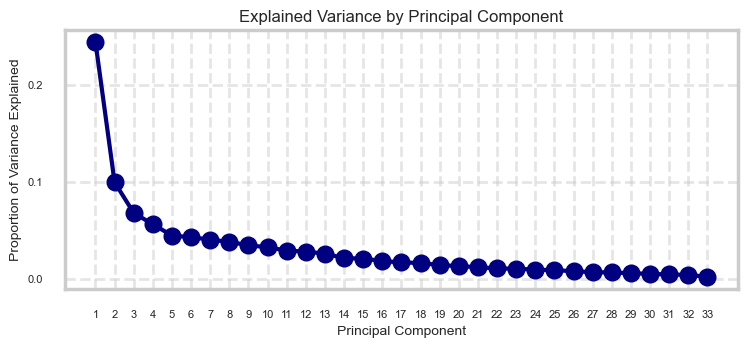

Cumulative Explained Variance Ratio by Dimension:
Dimension 1: 0.245
Dimension 2: 0.344
Dimension 3: 0.412
Dimension 4: 0.469
Dimension 5: 0.513
Dimension 6: 0.556
Dimension 7: 0.597
Dimension 8: 0.635
Dimension 9: 0.670
Dimension 10: 0.702
Dimension 11: 0.731
Dimension 12: 0.759
Dimension 13: 0.785
Dimension 14: 0.807
Dimension 15: 0.827
Dimension 16: 0.846
Dimension 17: 0.863
Dimension 18: 0.879
Dimension 19: 0.893
Dimension 20: 0.906
Dimension 21: 0.918
Dimension 22: 0.929
Dimension 23: 0.939
Dimension 24: 0.949
Dimension 25: 0.958
Dimension 26: 0.965
Dimension 27: 0.972
Dimension 28: 0.979
Dimension 29: 0.985
Dimension 30: 0.990
Dimension 31: 0.994
Dimension 32: 0.998
Dimension 33: 1.000

Approximate Optimal Number of Dimensions (Elbow Point): 2


In [215]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare data
X = pivoted.drop(columns=['customer_name']).to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA without restricting dimensions
pca = PCA()
pca.fit(X_scaled)

# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
variance = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(variance) + 1), variance, marker='o', linestyle='-', color='navy')

# Title and axis labels
plt.title("Explained Variance by Principal Component", fontsize=12)
plt.xlabel("Principal Component", fontsize=10)
plt.ylabel("Proportion of Variance Explained", fontsize=10)

# Smaller tick label fonts
plt.xticks(range(1, len(variance) + 1), fontsize=8)
plt.yticks(fontsize=8)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative Explained Variance Ratio by Dimension:")
for i, cum_var in enumerate(cumulative_variance, 1):
    print(f"Dimension {i}: {cum_var:.3f}")

# Identify the elbow point (where rate of descent slows)
# Visually inspect the plot; typically, the elbow is where adding dimensions yields diminishing returns
elbow_dimension = np.argmax(np.diff(pca.explained_variance_ratio_) < 0.01) + 2  # Approximate elbow
print(f"\nApproximate Optimal Number of Dimensions (Elbow Point): {elbow_dimension}")

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>


<p>Each algorithm employs a distinct approach to group data, leading to varied performance outcomes. Affinity Propagation automatically identified 25 clusters, likely over-segmenting the dataset and resulting in a weaker clustering structure, as indicated by a lower silhouette score. Spectral Clustering, when manually set to 3 clusters (aligned with the provided results), achieved the highest silhouette score of 0.224, making it the best performer numerically. However, this score still reflects a weak-to-moderate clustering structure, suggesting that while some separation is present, the data does not naturally form well-defined groups across its full 32-dimensional space.

This contrasts with earlier Principal Component Analysis (PCA) visualizations, where clusters may have appeared more distinct. PCA reduces the high-dimensional data to two dimensions, enhancing visual separation but potentially exaggerating patterns that are less pronounced in the original feature space. Consequently, while the PCA plot (explaining 21.5% of variance) may look cleaner, it does not necessarily indicate strong clustering from a statistical or structural perspective.

The varying silhouette scores across algorithms are expected, as each method relies on different clustering principles. For instance, DBSCAN struggled due to the absence of strong density-based separation, resulting in no clusters, while Agglomerative Clustering exhibited slightly weaker performance (0.086) compared to Spectral Clustering. Overall, although Spectral Clustering performed best among the tested methods, the relatively low silhouette score of 0.224 underscores that the natural clustering structure in the dataset remains weak, likely due to its sparse, high-dimensional nature.</p>
</div>



Clustering Results:
Algorithm                Clusters  Silhouette Score
--------------------------------------------------
Affinity Propagation     15        0.095
Spectral Clustering      3         0.224
Agglomerative Clustering 3         0.086
DBSCAN                   0         N/A


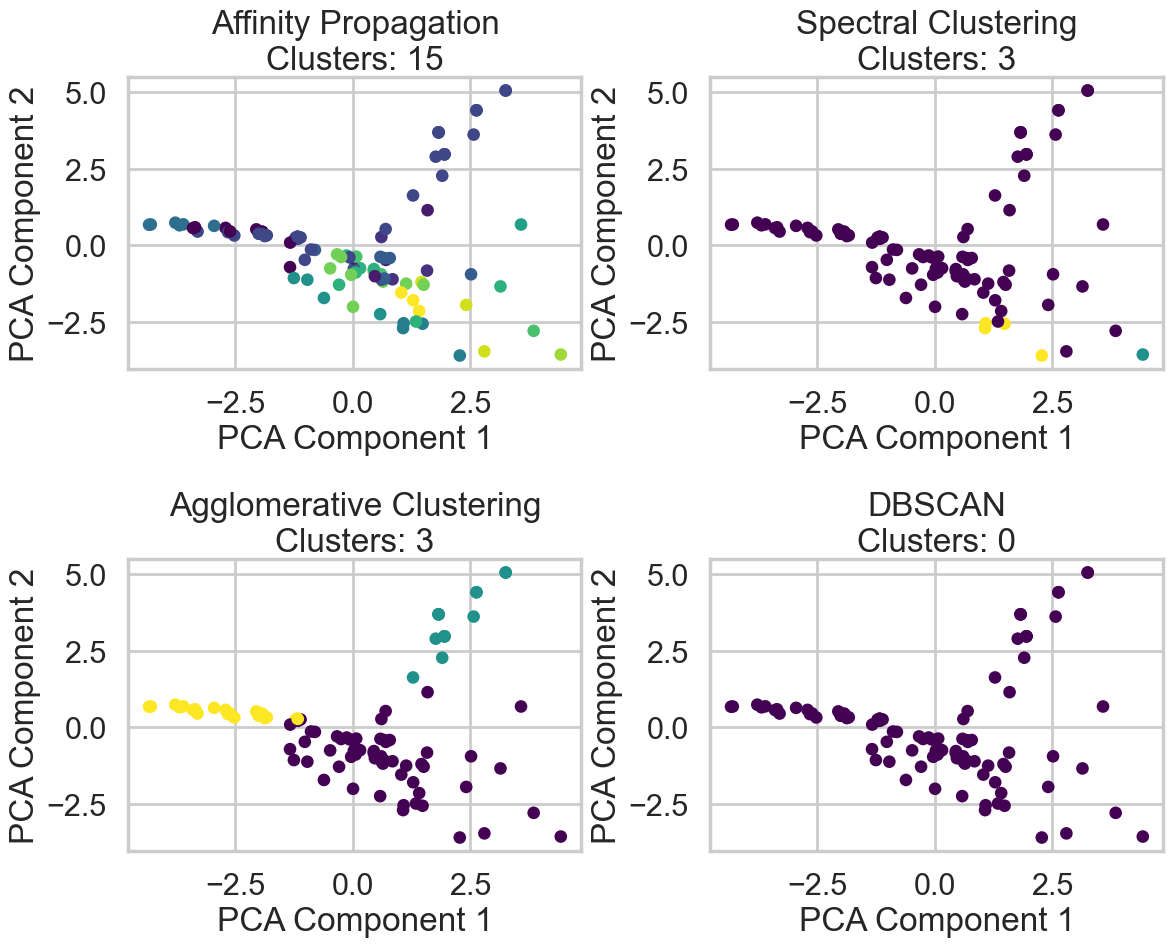


PCA Explained Variance Ratio: [0.11785935 0.09693357]
Total Variance Explained: 0.215


In [218]:

import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Prepare data
X = pivoted.drop(columns=['customer_name']).to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define clustering algorithms
algorithms = [
    ('Affinity Propagation', AffinityPropagation(damping=0.7, random_state=123)),
    ('Spectral Clustering', SpectralClustering(n_clusters=3, affinity='rbf', random_state=123)),
    ('Agglomerative Clustering', AgglomerativeClustering(n_clusters=3, linkage='ward')),
    ('DBSCAN', DBSCAN(eps=2.0, min_samples=5))
]

# Clustering and evaluation
results = []
for name, model in algorithms:
    labels = model.fit_predict(X_scaled)
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0) if name == 'DBSCAN' else len(unique_labels)
    silhouette = None
    if n_clusters > 1:
        try:
            silhouette = silhouette_score(X_scaled, labels)
        except ValueError:
            silhouette = None
    results.append((name, n_clusters, silhouette))

# Print results
print("\nClustering Results:")
print(f"{'Algorithm':<25}{'Clusters':<10}{'Silhouette Score'}")
print("-" * 50)
for name, n_clusters, silhouette in results:
    score_str = f"{silhouette:.3f}" if silhouette is not None else "N/A"
    print(f"{name:<25}{n_clusters:<10}{score_str}")

# PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
for i, (name, model) in enumerate(algorithms):
    labels = model.fit_predict(X_scaled)
    axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
    axes[i].set_title(f'{name}\nClusters: {len(set(labels) - {-1} if -1 in labels else set(labels))}')
    axes[i].set_xlabel('PCA Component 1')
    axes[i].set_ylabel('PCA Component 2')
plt.tight_layout()
plt.show()

print(f"\nPCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_):.3f}")